<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

In [ ]:
!nvidia-smi

Sat Jun 24 10:33:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


In [ ]:
!pip install -q tensorflow==2.3.0
!pip install Pillow==9.0.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done


Restart the Runtime
Note After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

Restart of the Colab Runtime Engine

### Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [ ]:
#!pip uninstall numpy
#!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
df= pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'Target distribution'}, ylabel='Frequency'>

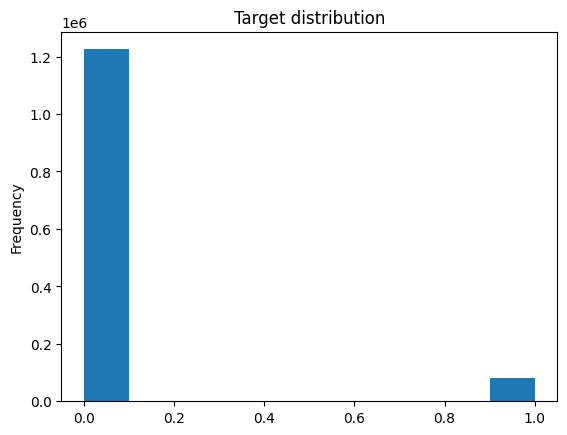

In [ ]:
df.target.plot(kind='hist', title='Target distribution')

## Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_df, remaining= train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _= train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1): #to get one text-pair
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features: input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
# Label categories
label_list = [0, 1]
# maximum length of (token) input sequences
max_seq_length = 128
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

# To instantiate the tokenizer, we need 1- Vocab file -> give the path of vocabulary file to tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# To check if the imported bert layer  is uncased version or case-sensetive version and then convert it into numpy
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# FullTokenizer: do all the needed preprocessing needed
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

**Tokenize and Preprocess Text for BERT**

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps.

First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.


Second, we convert those input examples into input features

In [ ]:
# Generate input mask: set max length of the input to 128, each sequence has to be padded to that max length, to get constant length tensor
# We don't want bert to attent to the padding sequence, so we use the input mask
# Input mask is a vector of the same length, which has a value of 1 corresponding to the input token id and a value of 0 corresponding to the padding zeros
# By taking the dot product of those 2 vectors, we only pay attention to the token ids

#Generate input type IDs: (= segment IDs)
# Bert is pre-trained on 2 tasks: 1- Mask language modeling -> where random words from the sentence would be masked and it was the task to predict what those words/mask tokens are
# 2- next sentence prediction (NSP): input to bert is 2 sequences/sentence and the task for bert to say which one is first (given the value zero) and which is the second (given the vale 1)
# Since we are dealing with only one sentence at a time for classification, so it will always be zero

# This provides a function to convert row to input features and label
# guid-> it is an id for each example, since we r dealing with one example at a time, we set it to None
# text_a => the text to be classified
# text_b => if we are gonna use next sentence prediction (NSP)
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())

  # convert the example into feature and labels
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Wrap a Python Function into a TensorFlow op for Eager

In [ ]:
def to_feature_map(text, label):
  # takes the text and label as input and return the output of type tensor int32
  # we need the shape of all those tensors to be 128, except for the shape of labels we will leave it blank, may binary classification, 3-class, 4, ... ?
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  # The to_feature method takes 2 inputs (text and label), so we have to bundle the 3 features (input_id, input_mask, segment_id) into 1 input dictionary
  x = {
      'input_word_ids':input_ids,
      'input_mask':input_mask,
      'input_type_ids':segment_ids
      }

  return (x, label_id)

##  Create a TensorFlow Input Pipeline with tf.data

In [ ]:
with tf.device('/cpu:0'):
  # here we will map each element on the input data. Cause the input elements are independant on each other, so the pre-processing can be done in parallel,
  # using num_parallel_calls, it depends on how many cores we have, so we can let tensorflow to do that automatically by AUTOTUNE
  # We will shuffle only training data, then batching them
  # Drop_remainder = True => if we have more examples than batch size, we can ignore them. To make all the batches equal
  # pre-fetching: overlap pre-processing and execution ==> while the model is executing a training step: s, the input pipeline is reading the data for step: s+1
  # doing so to reduce the step time to the max
  # in the background: the transformation uses a background thread and an internal buffer to prefetch elements from out input dataset
  # The number of elements to prefetch >= number of batches
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))



The resulting tf.data.Datasets return (features, labels) pairs, as expected by keras.Model.fit:



In [ ]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():

  input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs={
          'input_word_ids':input_word_ids,
          'input_mask':input_mask,
          'input_type_ids':input_type_ids},
      outputs=output)
  return model

## Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

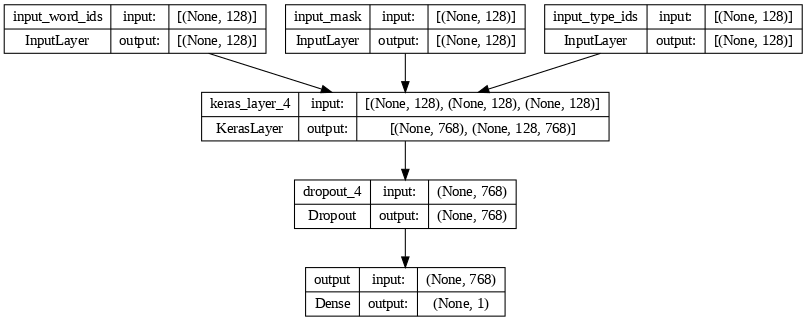

In [ ]:
#dpi ==> controls the size of the final image
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [ ]:
train_data

<_PrefetchDataset element_spec=({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32,), dtype=tf.int32, name=None))>

In [ ]:
#train model
epochs=4
history= model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    verbose=1
    )

Epoch 1/4
306/306 [==============================] - 317s 859ms/step - loss: 0.1854 - binary_accuracy: 0.9355 - val_loss: 0.1193 - val_binary_accuracy: 0.9510
Epoch 2/4
306/306 [==============================] - 263s 856ms/step - loss: 0.1050 - binary_accuracy: 0.9612 - val_loss: 0.1268 - val_binary_accuracy: 0.9604
Epoch 3/4
306/306 [==============================] - 261s 851ms/step - loss: 0.0601 - binary_accuracy: 0.9779 - val_loss: 0.1691 - val_binary_accuracy: 0.9469
Epoch 4/4
306/306 [==============================] - 262s 854ms/step - loss: 0.0251 - binary_accuracy: 0.9912 - val_loss: 0.2005 - val_binary_accuracy: 0.9604


## Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

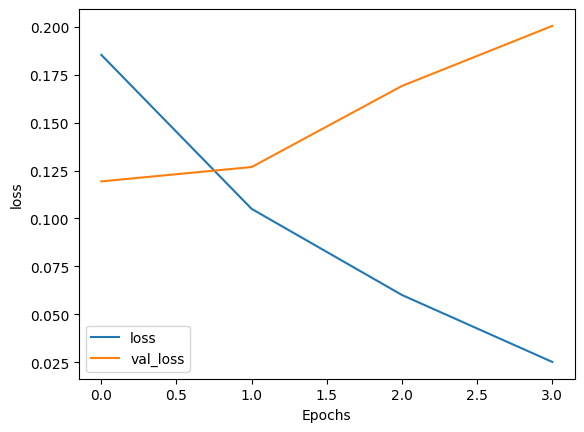

In [ ]:
plot_graphs(history, 'loss')

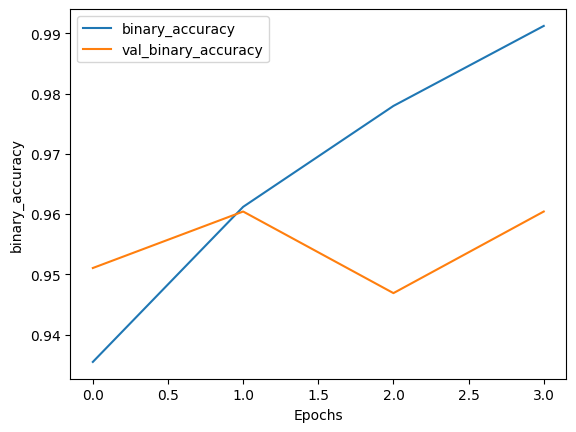

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
sample_example = ["sentence 1", ""]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
#threshold bet 0 and 1
threshold = 0.5
['Insincere' if pred>=threshold else 'sincere' for pred in preds]